(page:apres-theory)=
# ApRES theory
This page describes the theory behind the Autonomous Radio-echo sounder, including 
- a description of the linear chirps the system emits, 
- how individual and multiple reflectors are represented in the returned signal,
- how the range to these reflectors is encoded in the frequency content of returned signal, and 
- how to extract the range to reflectors using a fourier transform. 

## Overview
Many of the material below can be found in the [ApRES manual](https://github.com/ldeo-glaciology/phase-sensitive-radar-processing/blob/5cce6bd838cb70e290316195af9ceefe3d4a52ee/other%20documents/ApRES%20Manual%20V102.1.pdf), {cite}`brennan_phase-sensitive_2014`, and Nicholls et al. 2015. 

ApRES emits 'chirps', which consist of continuous radio waves lasting one second. Durin each chirp the frequency of the emmitted radio wave increases linearly with time from $f1$ to $f2$. The bandwidth of the system is defined as $B = f2-f1$. The signal is transmitted downwards into the ice sheet through one antenna (referred to by 'Tx' for transmit) and is partly reflected back to the radar's receiving (or 'Rx') antenna, where it is compared to the transmitted signal to determine the range to sub-surface reflectors. 

To be more specific, throughout each chirp, the radar continally compares the received signal and to the signal being tranmistted. Because the transmitted signal is increasing in frequency throughout the chirp and because the received signal was tranmitted upto 10's of micro-seconds earlier than it is received, the recieved signal is always lower frequency than the transmitted signal. In fact, the difference in the frequencies of the two signals is linearly proportional to the time it took the received signal to travel to the reflector and back. Finally, if we know the speed of radio waves in the ice, we can use this travel time to compute the range to a reflector. 

We will demonstrate how this is done for the simple case of one reflector, before explaining how this pplies when there are multiple reflectors. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from numpy.random import default_rng
import numpy as np
from scipy.signal import argrelextrema

## 1. Define a reflector
Suppose that there is just one reflector beneath you when you deploy ApRES. In reality there are hundreds, but we will assume there is just one.

Let's define the range to the two reflectors as

In [2]:
R = 110  # units [m]

## 2. Compute the two-way travel time to the reflector
If we assume uniform dialectric properties in the ice, we can consider how long it would take for a transmitted signal to travel to a reflector which has a range $R$, and back to the receiving antenna. This is called the 'two-way travel time' to a reflector and it is given by 
$$
\tau = 2R\frac{\sqrt\epsilon}{c},
$$

where $c$ is the speed of light in a vacuum and $\epsilon$ is the relative permittivity of ice.

We'll use constants from {cite}`brennan_phase-sensitive_2014`, to compute $\tau$ for our reflector:

In [3]:
c = 299792458
ep = 3.1
def tau(R):
    return 2*R*np.sqrt(ep)/c
print(f'two-way travel time, τ = {tau(R):.3e} s.')

two-way travel time, τ = 1.292e-06 s.


## 3. Plot the frequency of the transmitted signal
ApRES transmits one-second-long chirps of radio wave with a frequency that increases linearly from $f_1 = 200$ MHz to $f_2 = 300$ MHz:

In [4]:
T=1                 # chirp duration
f_1 = 200e6         # starting frequency
f_2 = 400e6         # ending frequency
f_c = (f_1+f_2)/2   # center frequency
B = f_2 - f_1       # bandwidth

Let's define a simple function which returns the frequency of the signal as a (linear) function of time. So that later we can demonstrate what it looks like when the returned signal is delayed by a given time, we add to the function an optional delay in seconds. The bandwidth $B$ and the center frequency $f_c$ are set by the design of the radar.

In [5]:
sampling_frequency = 40000    # [Hz]
t = np.linspace(0,T,sampling_frequency*T)   # time vector
def chirp(delay = 0):
    return f_1 + (t-delay)/T*(f_2-f_1)

Next we use this function to create and plot the frequency of the transmitted signal:

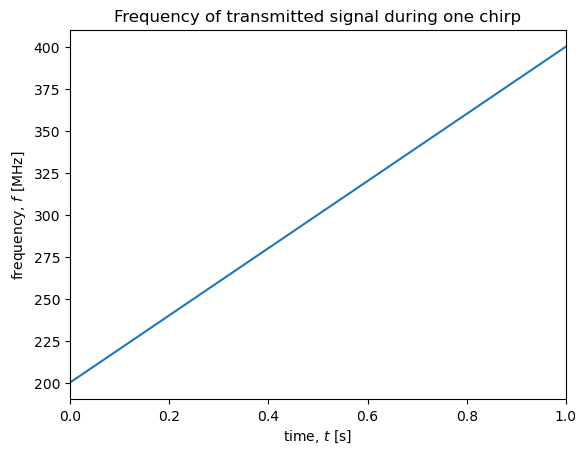

In [6]:
tx = chirp()

fig, ax = plt.subplots()
ax.plot(t,tx/1e6,'-', label ='transmitted signal')
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('frequency, $f$ [MHz]')
ax.set_title('Frequency of transmitted signal during one chirp')
ax.set_xlim(0, T);
plt.show()

## 4. Plot the frequency of the received signal
The signal received by ApRES is the same as the transmitted signal except that it has travelled to the reflector and back. This means that the received signal is delayed by the two-way travel time $\tau$ to the reflector.

We can use `chirp`, defined above, to generate a plot representing the frequency of the received signal and plot it with the frequency of the transmitted signal.

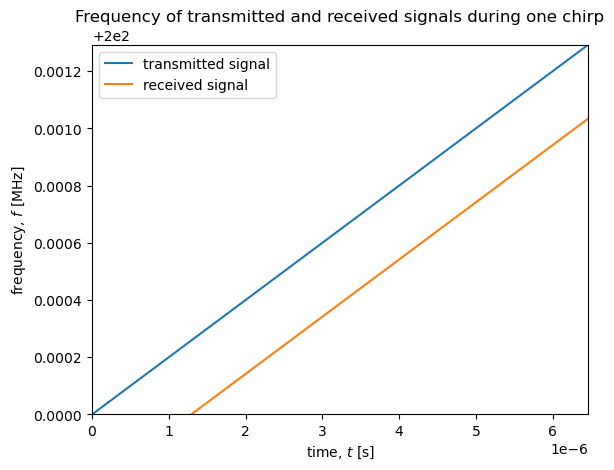

In [7]:
rx = chirp(tau(R))

fig, ax = plt.subplots()
ax.plot(t,tx/1e6, '-C0', label ='transmitted signal')
ax.plot(t,rx/1e6, '-C1', label ='received signal')
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('frequency, $f$ [MHz]')
ax.set_title('Frequency of transmitted and received signals during one chirp')
ax.legend()
ax.set_xlim(0, 5*tau(R));
ax.set_ylim(f_1/1e6, f_1/1e6+5*tau(R)*B/T/1e6);


Note that we have had to zoom into a the first few microseconds of the chirp to be able to see the delay in the received signal, because the two-way travel time, $\tau$, is so small compared to the total duration of the chirp.

We can see by eye that the horizontal distance between the two signals is the two-way travel time, $\tau$, as required:

In [8]:
tau(R)

1.292060425871348e-06

## 5. Compute the frequency difference
From the plot above you can see that the delay in the received signal causes a difference in the frequency of the transmitted and the received signals at each moment throughout a chirp. This frequency difference is equal to the vertical distance between the two curves.

Given the simple geometry of the plot, it is straightforward to relate this frequency difference, $f_d$, to the two-way-travel time, $\tau$:

$$
f_d = K\tau, 
$$

where $K$ is the rate of frequency increase in Hz/s, given by $K=B/T$, where $T$ is the chirp duration (1 s) (Equation 1 from Brennan et al.).

This can be understood by looking at the plot above and recognizing that $K$ is the slope of the curves, the vertical distance between them is the frequency difference, $f_d$, and the horozontal distance between them is the time delay, $\tau$.

Let's compute the frequency difference between the transmitted signal and the signal received from our reflector at a range of 110 m:  

In [9]:
K = B/T             # [Hz/s]
f_d = K*tau(R)         # [Hz]

print(f'The frequency difference for a reflector {R} m deep in ice is {f_d:.1f} Hz.')

The frequency difference for a reflector 110 m deep in ice is 258.4 Hz.


Note that this frequency is much lower than the transmitted and received signals. It is in the range that is audible to humans, rather than the MHz range of the transmitted and received signals. In fact, the frequency is very close to middle C. 

## 6. How does ApRES measure this frequency difference?
Above we defined the range to a reflector, $R$, and computed the difference, $f_d$, between the frequencies of the transmitted and received signals that this reflector would yield. In reality, we don't know $R$ apriori; we want to use ApRES to estimate $f_d$ so we can compute $R$. To estimate $f_d$, ApRES uses the concept of beat frequency. More details can be found [here](page:beat-frequency). 

In brief, when there is only one reflector, the received signal is a simple sine wave. It is mixed with the transmitted signal by electronics within the radar in real time during each chirp. The two signals interfere with each other in such a way as to generate a new signal, which has a frequency of $f_d/2$ (this signal also has a higher frequency component that is filtered out, also in real time, during each chirp). This frequency ($f_d/2$) is called the 'beat frequency' and the signal that comes of the mixer (and a low-pass filter) is called the 'deramped' signal. To compute the range to our single reflector we simply need to compute the frequency of the deramped signal and use the two equations above:

$$
f_d = K\tau, 
$$

$$
\tau = 2R\frac{\sqrt\epsilon}{c},
$$

which when combined and rearranged give:

$$
R = \frac{c}{2\sqrt\epsilon} \frac{f_d}{K}.
$$

This deramped signal is what is saved to disk by ApRES. We refer to these second-long deramped signals as 'chirps'.

## 7. Compute the frequency of this deramped signal with a fourier transform
In our simple case, the deramped signal looks like a sine wave:

$$
s = e^{2i\pi f_d t}
$$

In [10]:
s = np.exp(1j*2*np.pi*f_d*t)

Let's plot the real and imaginary parts of this signal:

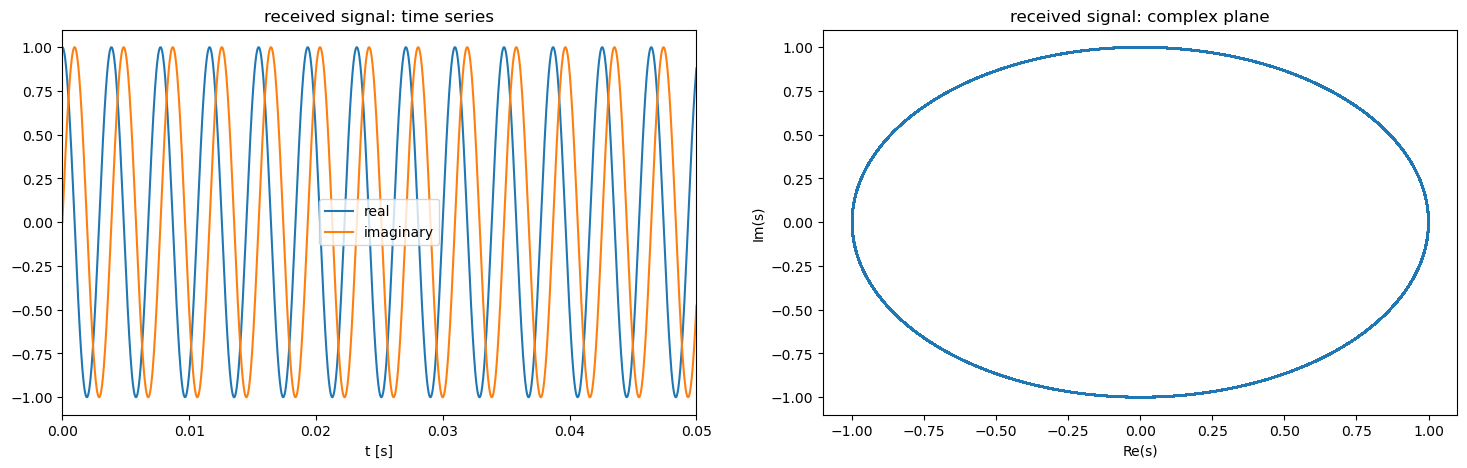

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

# the real and imaginary components of the signal in the plot on the left
ax1.plot(t,s.real, label='real')
ax1.set_title('received signal: time series')
ax1.set_xlabel('t [s]')
ax1.set_xlim(0, 0.05)
ax1.plot(t,s.imag, label='imaginary')
ax1.legend()

# the Argand diagram on the right
ax2.plot(s.real,s.imag)
ax2.set_title('received signal: complex plane')
ax2.set_ylabel('Im(s)');
ax2.set_xlabel('Re(s)');

As mentioned above, we need to compute the frequency of this signal. We do this using a fourier transform. [This video](https://www.youtube.com/watch?v=spUNpyF58B) is an incredibly clear explanation of how fourier transforms achieve this. 

The cell below computes the discrete fourier transform of `s` and the frequency bins. By default `np.fft.fft` produces as many frequency bins as there are time-domain samples (`=len(s)`), evenly distributed between 0 Hz and the sampling frequency. Therefore the values of the frequencies are computed by multiplying the indexes by `sampling_frequency/no_of_samples`. Note also that the frequency spectrum is normalized by the number of samples. 

In [12]:
def fft(s):
    no_of_samples = len(s)
    S = np.fft.fft(s)/no_of_samples         
    indexes      = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    return S, frequencies
S, frequencies = fft(s)

Next we compute the absolute value of the complex numbers in `S` and plot them against the frequencies yielding the usual depiction of frequency domain.

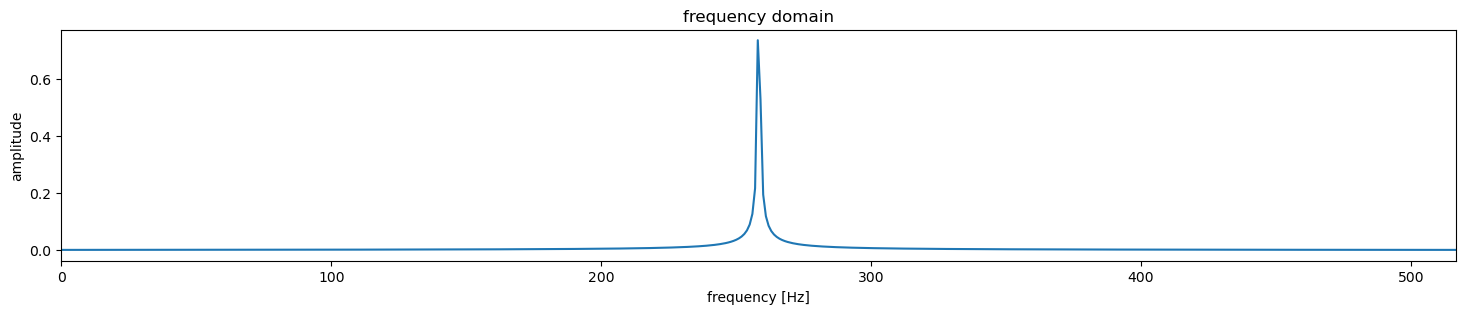

In [13]:
fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('frequency domain')
ax.plot(frequencies, np.abs(S))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('amplitude')
ax.set_xlim(0, 2*f_d);

We can now use the equation above, 

$$
R = \frac{c}{2\sqrt\epsilon} \frac{f_d}{K},
$$

to convert these frequencies to range,

In [14]:
def range(frequencies):
    return frequencies * c/(2*K*np.sqrt(ep))
r = range(frequencies)

and plot the result

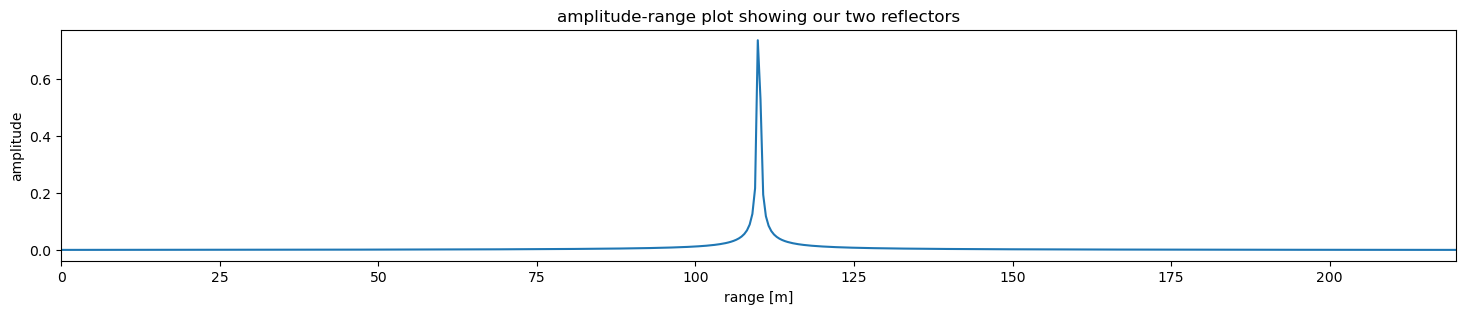

In [15]:
fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('amplitude-range plot showing our two reflectors')
ax.plot(r, np.abs(S))
ax.set_xlabel('range [m]')
ax.set_ylabel('amplitude')
ax.set_xlim(0, 2*R);

This range-amplitude plot is the ApRES equivalent of the usual time domain plot you would get from an impulse radar system: i.e. one which sends out a single pulse of radio-wave energy and records the echo from the reflector(s) beneath. 

As expected, in the plot above we see a peak at 110 m. We can detect the position of the peak using `argrelextrema`, a function from the pckage `scipy`. 

In [16]:
peaks = argrelextrema(np.abs(S), np.greater)      # this function finds local maxima  
print(f'reflector detected at {r[peaks[0][0]]:.3f} m.')

reflector detected at 109.825 m.


This is very close to the prescribed range of 110 m. However, because `frequencies` is quantized and (in our case) increases in 1 Hz increments, the retrieved  peaks are restricted to be an integer number of hertz. This is why Brennan et al. call this a *coarse* range measurment. 

## 9. The effect of bandwidth
The peak in the plot above has a non-zero width that is related to length of the deramped signal. For example, increasing the bandwidth, $B$, would decrease the width of the peak.

The function below collects together the important bits of the code above and generates a range-amplitude plot, and allows us to change key parameters like the bandwidth and chirp duration to explore their impact. 

For example, using a much smaller bandwidth of only 30 MHz results in a much wider peak in the range-amplitude plot.

starting frequency: 200000000.0 Hz
ending frequency: 400000000.0 Hz
B: 200000000.0 Hz
K: 200000000.0 Hz/s
T: 1 s
R: 80 m
sampling_frequency: 40000 Hz
two-way travel time: 9.397e-07 s
frequency of deramped signal: 187.9 Hz
number of cycles in deramped signal: 187.9
reflector detected at 80.027 m.


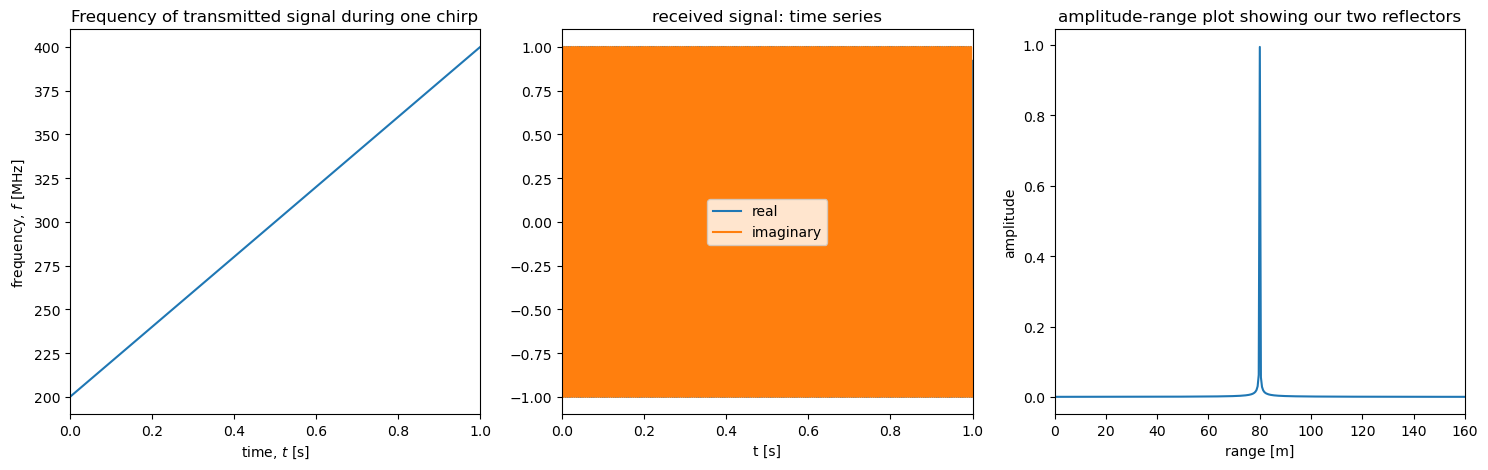

In [17]:
T = 1  # [s]
f_1 = 200e6  # [Hz]
f_2 = 400e6  # [Hz]
sampling_frequency = 40000   # [Hz]
R = 80   # [m]
t = np.linspace(0,T,int(sampling_frequency*T))   # time vector
B = f_2 - f_1       # bandwidth
K = B/T             # [Hz/s]

def amp_range_plot():

    tx = chirp()
    f_d = K*tau(R) 
    s = np.exp(1j*2*np.pi*f_d*t)
    S, frequencies = fft(s)
    r = range(frequencies)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    ax1.plot(t,tx/1e6,'-', label ='transmitted signal')
    ax1.set_xlabel('time, $t$ [s]')
    ax1.set_ylabel('frequency, $f$ [MHz]')
    ax1.set_title('Frequency of transmitted signal during one chirp')
    ax1.set_xlim(0, T)

    ax2.plot(t,s.real, label='real')
    ax2.set_title('received signal: time series')
    ax2.set_xlabel('t [s]')
    ax2.set_xlim(0, T)
    ax2.plot(t,s.imag, label='imaginary')
    ax2.legend()

    ax3.set_title('amplitude-range plot showing our two reflectors')
    ax3.plot(r, np.abs(S))
    ax3.set_xlabel('range [m]')
    ax3.set_ylabel('amplitude')
    ax3.set_xlim(0, 2*R)
    peaks = argrelextrema(np.abs(S), np.greater)     

    print(f"starting frequency: {f_1} Hz")
    print(f"ending frequency: {f_2} Hz")
    print(f"B: {B} Hz")
    print(f"K: {K} Hz/s")
    print(f"T: {T} s")
    print(f"R: {R} m")
    print(f"sampling_frequency: {sampling_frequency} Hz")
    print(f"two-way travel time: {tau(R):.3e} s")
    print(f"frequency of deramped signal: {f_d:.1f} Hz")
    print(f"number of cycles in deramped signal: {f_d*T:.1f}")
    print(f'reflector detected at {r[peaks[0][0]]:.3f} m.') 
    
    plt.show()
amp_range_plot()    

The lower resolution we see when $B$ is reduced is a result of their being fewer cycles in the deramped signal than in cases when $B$ is larger. The number of cycles in each chirp is given by 
$$
N = f_d T.
$$

The more cycles in a signal, the more precisely the fourier transform can determine its frequency. This is a fundamental property of fourier transforms and its crops up in many applications, including in quantum mechanics as the Heisenberg uncertainty principle. This is a great video on the subject from the same source as the video linked above about fouier transforms: https://www.youtube.com/watch?v=MBnnXbOM5S4. This video graphically demonstrates the idea that it is difficult for a foufier transform to determine the frequency of a short signal containing few cycles.

Interestingly, you will notice if you play around with the numbers in the cell above, that (all else being equal) the width of the peak does not depend on the chirp duration, $T$. At first sight this is surprising because you would expect that a longer duration chirp would contain more cycles and would therefore result in a narrower peak. However, notice that as you vary $T$, the number of cycles, which is printed out beneath the cell, does not change. This is because increasing $T$ while keeping $B$ constant decreases the rate of change of the frequency, $K$. This means that by the time the signal arrives back at the radar, the transmitted signal has not increased as much as it would have done if $K$ were larger. Therefore the frequency of the deramped signal, $f_d$, is lower than it would have been. 

A longer chirp duration tends to increase the number of cycles per chirp, but the decrease in frequency of the deramped signal $f_d$ counteracts this. In fact, the two effects balance exactly, resulting in the number of cycles per chirp being independent of $T$. 

Mathematically, we can show this by substituting $f_d = K\tau$ into the equation above,

$$
N = K\tau T.
$$

then substituting in $K=B/T$, which describes how $K$ decreases if $T$ increases (as described in words above) gives

$$
N = B\tau.
$$

From this we can see how the badnwidth $B$ effects the peak width, while $T$ does not; $T$ cancelling out in the last step above corresponds to the two effects descrbed above balancing each other exactly. 

## 10. Add more reflectors

So far we have considered just one reflectors. In general we simultaneously receive signals from reflectors at a whole range of depths. To give a feel for what this looks like, we will plot the frequency of ten signals with their delays selected randomly, to represent signals from ten reflectors at different depths. 

First let's redfine a few functions to make sure to avoid any issues with varied parameter from the previous section.

In [18]:
c = 299792458
ep = 3.1
def tau(R):
    return 2*R*np.sqrt(ep)/c
T=1                 # chirp duration
f_1 = 200e6         # starting frequency
f_2 = 400e6         # ending frequency
f_c = (f_1+f_2)/2   # center frequency
B = f_2 - f_1       # bandwidth
sampling_frequency = 40000    # [Hz]
t = np.linspace(0,T,sampling_frequency*T)   # time vector
def chirp(delay = 0):
    return f_1 + (t-delay)/T*(f_2-f_1)
def fft(s):
    no_of_samples = len(s)
    S = np.fft.fft(s)/no_of_samples         
    indexes      = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    return S, frequencies
def range(frequencies):
    return frequencies * c/(2*K*np.sqrt(ep))

Next, let's define our ten reflectors at random depths and plot the frequency of the received signals from each reflector.

Plotting the frequencies of signals reflected from the following depths: [  3.37514327 889.26122168 586.31305979 135.63533655 101.12516631
 961.89128611  58.38920621 963.510313   556.00188035 288.82637573] m


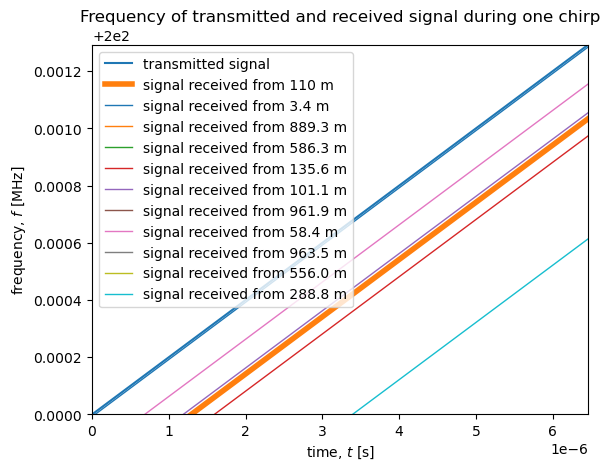

In [19]:
R = 110
rx = chirp(tau(R))

fig, ax = plt.subplots()
ax.plot(t,tx/1e6, '-C0', label ='transmitted signal')
ax.plot(t,rx/1e6, '-C1', label ='signal received from 110 m', linewidth = 4)
# generate some randomly delayed signals
rng = default_rng(seed = 4321)
ranges = np.absolute(rng.uniform(0, R*10, 10)) # np.array([110, 3, 30]) #


print(f"Plotting the frequencies of signals reflected from the following depths: {ranges} m")
for i, r in enumerate(ranges):
    rx_rnd = chirp(tau(r))
    ax.plot(t,rx_rnd/1e6,'-', label =f'signal received from {r:.1f} m', linewidth = 1)


ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('frequency, $f$ [MHz]')
ax.set_title('Frequency of transmitted and received signal during one chirp')
ax.legend()
ax.set_xlim(0, 5*tau(R));
ax.set_ylim(f_1/1e6, f_1/1e6+5*tau(R)*B/T/1e6);

In practice, signals from all the reflectors are combined togather and arrive back at the radar simultaneously, thoughout the chirp. This means that the signal received by the radar is the sum of signals reflected by many reflectors - hundreds or thousands in reality, compared to the ten we plotted above. Moreover, the signals all have slightly different frequencies differences, $f_d$, depending on the range to each reflector. Let's generate the deramped signal that these ten reflectors would yield and plot it. 

We first compute the frequency differences for each reflector:

In [20]:
f_d = K*tau(ranges)         # [Hz] 

For each frequency difference we then generate a complex signal with that frequency:

In [21]:
chirp_list = [np.exp(2*np.pi*1j*x*t) for x in f_d]


Finally, we sum them together to create one signal.

In [22]:
chirp_array = np.stack(chirp_list, axis=1)
s = chirp_array.sum(axis=1)

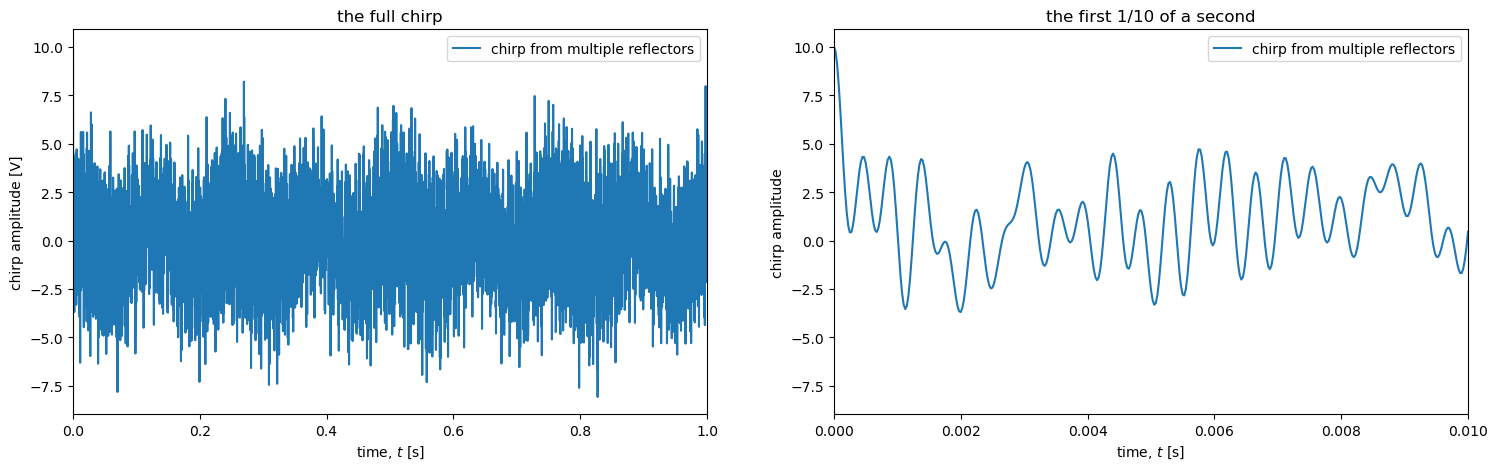

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

ax1.plot(t, s.real, label ='chirp from multiple reflectors')
ax1.set_xlabel('time, $t$ [s]')
ax1.set_ylabel('chirp amplitude [V]')
ax1.set_title('the full chirp')
ax1.set_xlim(0, 1)
ax1.legend()

ax2.plot(t, s.real, label ='chirp from multiple reflectors')
ax2.set_xlabel('time, $t$ [s]')
ax2.set_ylabel('chirp amplitude')
ax2.set_title('the first 1/10 of a second')
ax2.set_xlim(0, 0.01)
ax2.legend()

The plot above shows what ApRES would record to disk if in our simple 10-reflector case. The signal has ten frequency components, each correspondong to one reflector. The challenge now is to estimate these frequency componets to determine the range to all the reflectors. As above, we use a fourier transform. 

## 11. Compute the frequency componets using a fourier transform

Using the same approach as we did in the single-reflector case, we apply a fourier transform to the deramped signal to extract the frequency components, then convert the frequencies to range:

In [24]:
S, frequencies = fft(s)
r = range(frequencies)

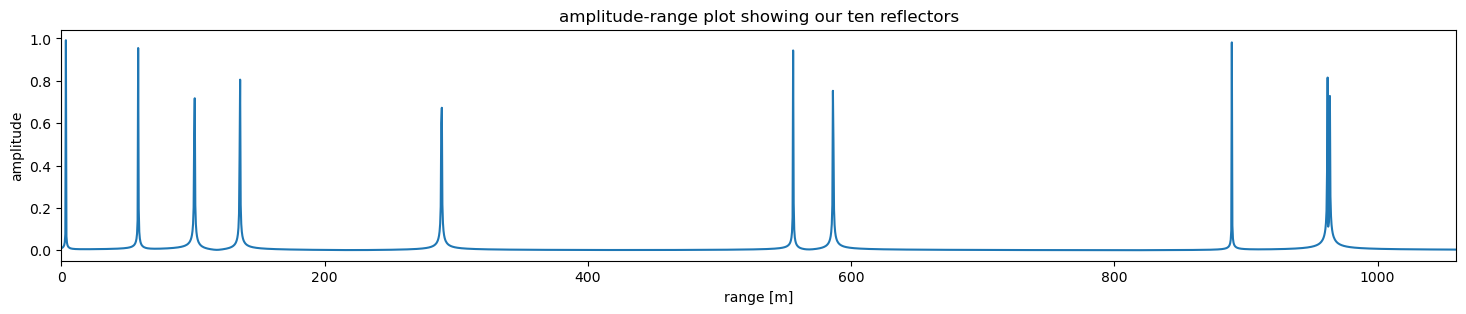

In [25]:
fig,ax = plt.subplots(figsize=(18,3))
ax.set_title('amplitude-range plot showing our ten reflectors')
ax.plot(r, np.abs(S))
ax.set_xlabel('range [m]')
ax.set_ylabel('amplitude')
ax.set_xlim(0, np.max(ranges)*1.1);

FInally, we can extract the peaks as we did before.

In [26]:
peaks = argrelextrema(np.abs(S), np.greater)     
print(f'reflectors detected at {r[peaks[0]]} m.')    

reflectors detected at [  3.40541349  58.31770596 101.31105123 135.79086279 289.03446969
 555.93375172 586.15679641 889.23859674 962.02931002 963.73201676] m.


These are all close to the ranges we prescribed:

In [27]:
np.sort(ranges)

array([  3.37514327,  58.38920621, 101.12516631, 135.63533655,
       288.82637573, 556.00188035, 586.31305979, 889.26122168,
       961.89128611, 963.510313  ])

In [28]:
np.sort(ranges)-r[peaks[0]]

array([-0.03027021,  0.07150025, -0.18588493, -0.15552623, -0.20809396,
        0.06812864,  0.15626338,  0.02262495, -0.13802391, -0.22170375])

12. Summary
- ApRES emits one-second-long chirps. 
- ApRES detects the range to sub-surface reflectors by combined the frequency of a transmitted signal, which continually increases throughout each chirp, to the frequency of the signal received from the reflectors. 
- The tranmistted and received signal are in the MHz range. 
- This combination results in a 'deramped' signal which is in the audio frequency range.
- The deramped signal is saved to disk by ApRES. 
- The frequency components of the deramped signal are extracted using a fourier transform to determine the range to sub-surface reflectors.
- The range-amplitude results, `S`, can be used to compute deisplacement of reflectors using cross-correlation betweeen successive measurements.